In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Get column names
print(f'Measurement col names')
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

print("-"*20)
print(f'Satation col names')
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

Measurement col names
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
Satation col names
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date[0])

2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Perform operation to dynamically calculate last date
# Calculate the date one year from the last date in data set.
# Get last date as a datetime object
# last_date.date is a string as [YYYY-MM-DD]
date_time_obj = dt.datetime.strptime(last_date.date, '%Y-%m-%d')
# Parse out Y/M/D
day_obj = date_time_obj.strftime("%d")
mo_obj = date_time_obj.strftime("%m")
# While parsing out Y, subtract 1 year
year_obj = str(int(date_time_obj.strftime("%Y")) - 1)
# Rebuild string to find "one year ago" date
year_ago_str = f'{year_obj}-{mo_obj}-{day_obj}'
year_ago_str

'2016-08-23'

<function matplotlib.pyplot.show(*args, **kw)>

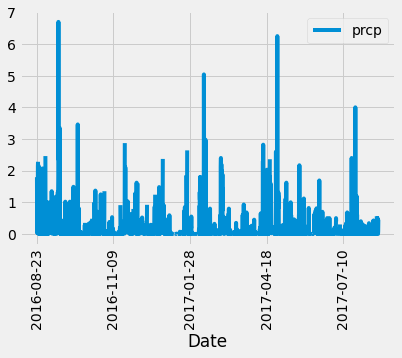

In [13]:
# Perform a query to retrieve the data and precipitation scores
last_12_mo = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_prcp = pd.DataFrame(last_12_mo, columns=['Date', 'prcp',])
last_12_prcp_reindex = last_12_prcp.set_index("Date")

# Sort the dataframe by date
last_12_prcp_sorted = last_12_prcp_reindex.sort_values("Date")
last_12_prcp_sorted

# Use Pandas Plotting with Matplotlib to plot the data
last_12_prcp_sorted.plot(rot = 90)
plt.show

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_prcp_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
station_count

9

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())
station_active.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = station_active.all()[0][0]

sel = [func.max(Measurement.tobs),
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs)]
most_active_data = session.query(*sel).filter(Measurement.station == most_active).all()
most_active_data


[(85.0, 54.0, 71.66378066378067)]

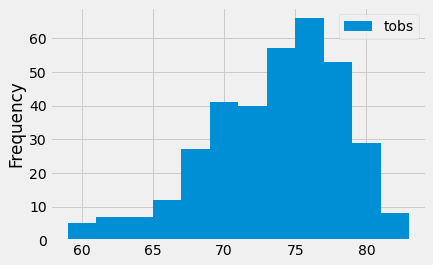

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12_mo_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= year_ago_str).filter(Measurement.station == most_active).all()
last_12_tobs_df = pd.DataFrame(last_12_mo_tobs, columns=['Date', 'tobs',])
last_12_tobs_df.plot.hist(bins = 12)
plt.show()

# Close session

In [ ]:
# Close Session
session.close()